# Sanity check with cluster simulation

In [1]:
%load_ext autoreload
%autoreload 2
from mmcontext.utils import setup_logging

setup_logging()

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


<RootLogger root (INFO)>

In [2]:
import numpy as np

from mmcontext.mmcontextencoder import MMContextEncoder
from mmcontext.sanity_helpers import cluster_variances, plot_pca, stack_embeddings
from mmcontext.simulator import OmicsCaptionSimulator, make_cluster_sampler

sim = OmicsCaptionSimulator(n_samples=5000, numeric_sampler=None).simulate()
cell_types = list(sim.adata.obs["cell_type"])
sim.numeric_sampler = make_cluster_sampler(labels=cell_types, noise=0.5)
sim._build_embeddings()
gene_df, sample_df = sim.get_dataframes()
# Dataset for MultipleNegativesRankingLoss, MultipleNegativesSymmetricRankingLoss (anchor–positive pairs, no label)
sim._build_hf_dataset(preset="pair")
mn_ds = sim.get_hf_dataset()

# Dataset for TripletLoss, MultipleNegativesRankingLoss (triplets)
sim._build_hf_dataset(preset="triplet")
triplet_ds = sim.get_hf_dataset()

# Dataset for ContrastiveLoss, OnlineContrastiveLoss with 0/1 label
sim._build_hf_dataset(preset="pair-binary")
contrastive_ds = sim.get_hf_dataset()
# Dataset for BatchAllTripletLoss, BatchHardSoftMarginTripletLoss,BatchHardTripletLoss,BatchSemiHardTripletLoss (single sentence, integer (class) label)
sim._build_hf_dataset(preset="single-class")
single_ds = sim.get_hf_dataset()

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Filter: 100%|██████████| 10000/10000 [00:00<00:00, 582615.05 examples/s]
2025-07-09 16:21:11,115 - mmcontext.simulator - INFO - No batch_labels provided – assigned 2 random batches
Filter: 100%|██████████| 5000/5000 [00:00<00:00, 717073.10 examples/s]


In [3]:
from sentence_transformers import SentenceTransformer

enc = MMContextEncoder(
    "one_hot", adapter_hidden_dim=None, adapter_output_dim=64, freeze_text_encoder=True, train_lookup=False
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
st = SentenceTransformer(modules=[enc])

2025-07-09 16:21:23,449 - mmcontext.omicsencoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-07-09 16:21:23,449 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-07-09 16:21:23,464 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


In [5]:
train, val = single_ds["train"], single_ds["val"]
train_sample_idx = train["sample_idx"]
val_sample_idx = val["sample_idx"]
train_2 = train.remove_columns(["sample_idx"])
val_2 = val.remove_columns(["sample_idx"])

In [6]:
from sentence_transformers import SentenceTransformerTrainer, SentenceTransformerTrainingArguments, losses

out_dir = "./models/demo_random"

loss = losses.BatchHardTripletLoss(model=st)
args = SentenceTransformerTrainingArguments(
    output_dir=out_dir,
    num_train_epochs=4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=3e-3,
    logging_steps=50,
    run_name="sanity_check_2",
    report_to="wandb",
)
trainer = SentenceTransformerTrainer(
    model=st,
    args=args,
    train_dataset=train_2,
    eval_dataset=val_2,
    loss=loss,
)
trainer.train()

wandb: Currently logged in as: mengerj (mengerj-universit-tsklinikum-freiburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa


/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.275800
100,0.403600


2025-07-09 16:21:44,454 - sentence_transformers.trainer - INFO - Saving model checkpoint to ./models/demo_random/checkpoint-128
2025-07-09 16:21:44,455 - sentence_transformers.SentenceTransformer - INFO - Save model to ./models/demo_random/checkpoint-128


TrainOutput(global_step=128, training_loss=0.7261166200041771, metrics={'train_runtime': 9.7889, 'train_samples_per_second': 1634.501, 'train_steps_per_second': 13.076, 'total_flos': 0.0, 'train_loss': 0.7261166200041771, 'epoch': 4.0})

In [7]:
# train_sub = train.filter(lambda x: x["label"] == 1.0)
new_emb = st.encode(train["sentence"])
new_labels = sim.adata.obs["cell_type"][train_sample_idx]

Batches: 100%|██████████| 125/125 [00:00<00:00, 228.16it/s]


In [11]:
trained_text = st.encode(train["sentence"])
trained_label = train["label"]

Batches: 100%|██████████| 125/125 [00:00<00:00, 227.77it/s]


In [12]:
embeddings = stack_embeddings(sample_df)

In [13]:
within0, between0 = cluster_variances(embeddings, cell_types)
within1, between1, sil1 = cluster_variances(new_emb, new_labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

initial  : within=0.2506   between=0.8093
trained  : within=0.1425   between=1.1777   sil=0.885


In [14]:
old_emb = embeddings
old_labels = cell_types
# text_emb = trained_text
# text_labels = trained_label

<Axes: title={'center': 'random-proj after'}, xlabel='PC1', ylabel='PC2'>

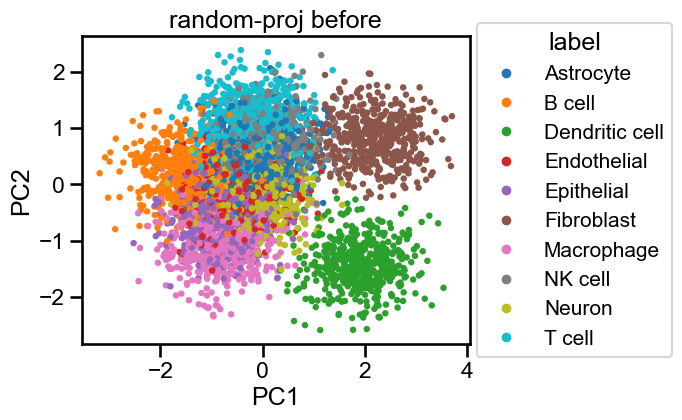

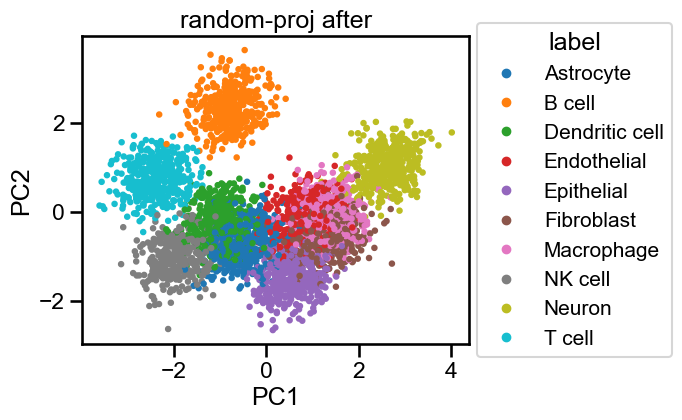

In [15]:
rng = np.random.default_rng(42)
k = 2  # final dims
R_old = rng.standard_normal((old_emb.shape[1], k))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)

# If new_emb has a *different* dim, regenerate a matching matrix
R_new = rng.standard_normal((new_emb.shape[1], k))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

# R_text = rng.standard_normal((text_emb.shape[1], k))
# R_text /= np.linalg.norm(R_text, axis=0, keepdims=True)

old_2d = old_emb @ R_old  # (N, 2)
new_2d = new_emb @ R_new
# text_2d = text_emb @ R_text

plot_pca(old_2d, old_labels, title="random-proj before", point_size=10, legend_out=True)
plot_pca(new_2d, new_labels, title="random-proj after", point_size=10, legend_out=True)
# plot_pca(text_2d, text_labels, title="random-proj text",
#         point_size=10, legend_out=True)